In [32]:
from numpy import *
from PlotFuncs import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numba import jit
from numpy import random
from scipy.integrate import cumtrapz
import cmocean
from tqdm import tqdm

def costh2N(t,costh_X,phi_X,lat):
    # t in days
    lat *= pi/180
    wt = 2*pi*t
    th_X = arccos(costh_X)
    return (sin(th_X)*cos(phi_X)*sin(lat)*cos(wt) - sin(th_X)*sin(phi_X)*sin(lat)*sin(wt) + costh_X*cos(lat))**2

def costh2W(t,costh_X,phi_X,lat):
    # t in days
    lat *= pi/180
    wt = 2*pi*t
    th_X = arccos(costh_X)
    return (sin(th_X)*cos(phi_X)*sin(wt) - sin(th_X)*sin(phi_X)*cos(wt))**2

def costh2Z(t,costh_X,phi_X,lat):
    # t in days
    lat *= pi/180
    wt = 2*pi*t
    th_X = arccos(costh_X)
    return (sin(th_X)*cos(phi_X)*cos(lat)*cos(wt) + sin(th_X)*sin(phi_X)*cos(lat)*sin(wt) + costh_X*sin(lat))**2

def costh2ZW(t,costh_X,phi_X,lat):
    return 1 - costh2N(t,costh_X,phi_X,lat)

def costh2ZN(t,costh_X,phi_X,lat):
    return 1 - costh2W(t,costh_X,phi_X,lat)

def costh2NW(t,costh_X,phi_X,lat):
    return 1 - costh2Z(t,costh_X,phi_X,lat)


def costh_T_samples(fcosth2,lat,T,nt=1000,ngen=1000):
    costh_X = 2*random.uniform(size=ngen)-1
    phi_X = 2*pi*random.uniform(size=ngen)
    t_vals = linspace(0,T,nt)
    c1t = zeros(shape=(ngen,nt))
    for i in range(0,nt):
        c1t[:,i] = fcosth2(t_vals[i],costh_X,phi_X,lat)

    c_av = trapz(c1t,t_vals)/T
    return c_av

ngen = 1000

P_true = 5.0
S_true = P_true*(1/3)
sigma_N = 1.0
N_true = 1.0
costh_samples = costh_T_samples(costh2Z,55.0,1.0,ngen=ngen)

N_samples = random.normal(loc=N_true,scale=sigma_N,size=ngen)

P_obs = P_true*costh_samples + N_samples

(array([  2.,  13.,  38., 119., 192., 238., 203., 120.,  63.,  12.]),
 array([-1.88099074, -1.1923284 , -0.50366607,  0.18499627,  0.8736586 ,
         1.56232094,  2.25098328,  2.93964561,  3.62830795,  4.31697028,
         5.00563262]),
 <a list of 10 Patch objects>)

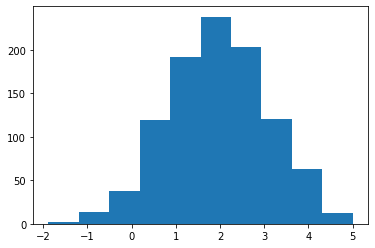

In [24]:
plt.hist(P_obs)

0.00872

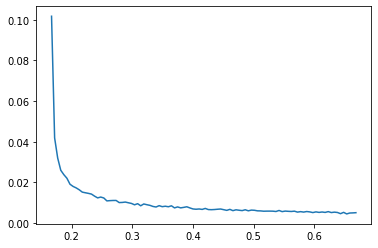

In [115]:
h,ce = histogram(costh_T_samples(costh2Z,55.0,1.0,ngen=100000),100)
cc = (ce[1:]+ce[0:-1])/2
P_costh = h/sum(h)
plt.plot(cc,P_costh)

costh_obs = 0.33
P_costh[argmin(abs(cc-costh_obs))]

In [120]:
from scipy.optimize import minimize

n_expts = 500
TS0 = zeros(shape=n_expts)
TS1 = zeros(shape=n_expts)

bnds1 = ((0, None), (0,None),(None, None))
bnds0 = ((0, None),)


P_true = 20.0
S_true = P_true*(1/3)
sigma_N = 1.0
N_true = 1.0
costh_samples = costh_T_samples(costh2Z,55.0,1.0,ngen=n_expts)
N_samples = random.normal(loc=N_true,scale=sigma_N,size=n_expts)
P_obs1 = P_true*costh_samples + N_samples
P_obs0 = N_samples

for expt in tqdm(range(0,n_expts)):
    logL1 = lambda x : 0.5*(P_obs1[expt]-x[0]*x[1]-x[2])**2/sigma_N**2 + 0.5*(N_true-x[2])**2/sigma_N**2 - log(P_costh[argmin(abs(cc-x[1]))])
    logL0 = lambda x : 0.5*(P_obs1[expt]-x[0])**2/sigma_N**2 + 0.5*(N_true-x[0])**2/sigma_N**2

    x1 = array([P_true,costh_samples[expt],N_samples[expt]])
    x0 = array([P_obs])
    res1 = minimize(logL1,x1,bounds=bnds1)
    res0 = minimize(logL0,x0)
    TS1[expt] = -2*(logL1(res1.x)-logL0(res0.x))
    
for expt in tqdm(range(0,n_expts)):
    logL1 = lambda x : 0.5*(P_obs0[expt]-x[0]*x[1]-x[2])**2/sigma_N**2 + 0.5*(N_true-x[2])**2/sigma_N**2 - log(P_costh[argmin(abs(cc-x[1]))])
    logL0 = lambda x : 0.5*(P_obs0[expt]-x[0])**2/sigma_N**2 + 0.5*(N_true-x[0])**2/sigma_N**2

    x1 = array([P_true,costh_samples[expt],N_samples[expt]])
    x0 = array([P_obs])
    res1 = minimize(logL1,x1,bounds=bnds1)
    res0 = minimize(logL0,x0)
    TS0[expt] = -2*(logL1(res1.x)-logL0(res0.x))

100%|██████████| 500/500 [00:23<00:00, 21.44it/s]


(array([216., 101.,  51.,  29.,  31.,  26.,  19.,  20.,   4.,   3.]),
 array([ -4.11524582,   6.44952304,  17.01429189,  27.57906075,
         38.1438296 ,  48.70859846,  59.27336732,  69.83813617,
         80.40290503,  90.96767389, 101.53244274]),
 <a list of 10 Patch objects>)

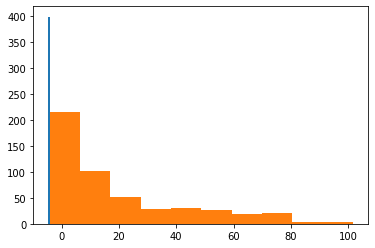

In [123]:
plt.hist(TS0)
plt.hist(TS1)

(array([15., 80., 98., 89., 64., 38., 39., 40., 30.,  7.]),
 array([ 1.95520692,  3.35692071,  4.7586345 ,  6.16034829,  7.56206208,
         8.96377586, 10.36548965, 11.76720344, 13.16891723, 14.57063102,
        15.97234481]),
 <a list of 10 Patch objects>)

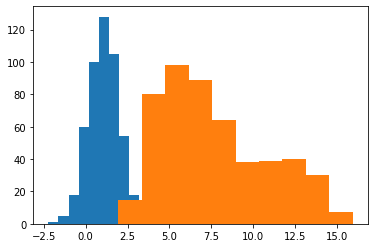

In [126]:
plt.hist(P_obs0)
plt.hist(P_obs1)

0.9543

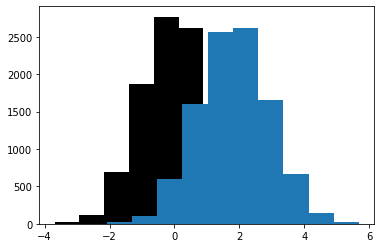

In [156]:
n_expts = 10000
P_true = 5.5
sigma_N = 1.0
N_true = 0.0
costh_samples = costh_T_samples(costh2Z,45.0,1.0,ngen=n_expts)
N_samples = random.normal(loc=N_true,scale=sigma_N,size=n_expts)
P_obs1 = P_true*costh_samples + N_samples
P_obs0 = N_samples
plt.hist(P_obs0,color='k')
plt.hist(P_obs1)
sum(P_obs1>median(P_obs0))/n_expts

In [157]:
costh_95 = sort(costh_samples)[int(0.05*n_expts)]
costh_95*P_true

1.3785406942228924

In [71]:
res1.x

array([2.23931446, 0.99999762])

In [41]:
S_true

1.6666666666666665

In [42]:
N_true

1.0

In [52]:
logL1(array([S_true,N_true]))

1.1117179183169736

In [51]:
logL1(res1.x)

9.367424821130336e-13

In [53]:
P_obs[-1]-res1.x[0]-res1.x[1]

1.1406983705386509e-06

In [54]:
P_obs[-1]-P_true*costh_samples[-1]-N_samples[-1]

0.0

In [56]:
res0.x

array([0.57171238])

In [162]:
ang = 45/2*(pi/180)

cos(ang)

0.9238795325112867

In [161]:
sin(ang)**2 + cos(ang)**2

1.0

In [163]:
sin(ang)

0.3826834323650898